In [3]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time

In [27]:
from compilers import TrotterSim
sim = TrotterSim([np.array([[0,1], [1,0]])])
print(sim.simulate(np.pi / 2, 4)) #output state should be sigma_X |0> = |1>

[[0.+0.j]
 [0.+1.j]]


### Hamiltonian Generation

In [4]:
epsilon = 0.01
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)

In [5]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ])
hj = [1.0, 2.0, 3.0, 4.0] #list of normalized coefficients
lambd = sum(hj)
#t = 10
gamma = 2
alphacomm = 4 * lambd**3
#r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive

L = 4 #number of terms in the Hamiltonian
InitialState = [1/(2**(1/2)), 0, 1/(2**(1/2)), 0]
print(Hlist.shape)

(4, 4, 4)


### Trotter-Suzuki Second Order Simulation

In [6]:
def S2Trotter(Hlist, t, r): #Creates a list of all of the evolution operators in 2nd order Trotter-Suzuki
    U = []
    for i in range(0, 4):
        U.append((math.cos(t*hj[i]/(2*r)))*(Hlist[i, :, :]) - 1j*math.sin(t*hj[i]/(2*r))*II)
    for i in range(1, 5): 
        U.append((math.cos(t*hj[-i]/(2*r)))*(Hlist[-i, :, :]) - 1j*math.sin(t*hj[-i]/(2*r))*II)
    return U #Takes in Hamiltonian terms and converts them each into evolution operators

In [7]:
S2 = S2Trotter(Hlist) #A list of all of the evolution operators in 2nd order Trotter-Suzuki
#dim = len(S2)
def EvolveStore(S2): #Applies each of the evolution operators storing the previous state in a matrix row
    Psi = np.zeros((r*dim + 1, 4), dtype = complex)
    Psi[0, :] = InitialState
    for i in range(dim*r):
        Psi[i+1, :] = S2[i%8] @ Psi[i, :] # %8 is because one application of S2 trotter has 8 ops when N=4
    return Psi

TypeError: S2Trotter() missing 2 required positional arguments: 't' and 'r'

In [8]:
def S2_Comp(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2Trotter(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(1, dim*r):
        Psi = TrotterOps[i%8] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4, also = 2L
    
    infidelity = math.sqrt((TrueState - Psi) @ np.conjugate(TrueState - Psi))
    
    return infidelity

In [9]:
A = EvolveStore(S2)

sum(np.abs(A[48, :])**2) #checks normalization at any point in time (as in after a certain number of gates).


NameError: name 'EvolveStore' is not defined

In [10]:
l = [1, 2, 3, 4]
print(l[4%4])
print(range(0,9))

1
range(0, 9)


### QDRIFT Simulator

In [11]:
x=random.rand()
print(x)

0.4435133095901205


In [12]:
lambd = sum(hj)
#N = int(2*(lambd**2)*(t**2)/epsilon)
#tau = t*lambd/N
def QdriftPool(Hlist,t, N):
    tau = t*lambd/N
    U = []
    for i in range(0, 4):
        U.append((math.cos(tau))*(Hlist[i, :, :]) - 1j*math.sin(tau)*II)
    return U

def SumRange(hj, m, n):
    #list of terms hj, m, n the min and max of the sum range
    l = 0
    for i in range(m, n):
          l += hj[i]
    return l

In [13]:
DriftOps = QdriftPool(Hlist) #requires that hj be ordered least to greatest at the moment 
def QDRIFTstoring(Hlist, hj): # also does not work if 2 terms are the same size 
    Psi = np.zeros((N + 1, 4), dtype = complex)
    Psi[0, :] = InitialState
    for i in range(0, N):
        x = random.rand() 
        for j in range(L):
            if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd: #fix this with sums
                   Psi[i+1, :] = DriftOps[j+1] @ Psi[i]
            
            elif (sum(hj) - hj[3])/lambd < x <=1:
                Psi[i+1, :] = DriftOps[3] @ Psi[i]
            
            elif 0 < x <=hj[0]/lambd:
                Psi[i+1, :] = DriftOps[0] @ Psi[i] #elif statements are written knowing max and min of hj
            
            else:
                pass
    return Psi #not working correctly see below

TypeError: QdriftPool() missing 2 required positional arguments: 't' and 'N'

In [14]:
def QDRIFT_comp(OperatorCoeffs, OperatorBin, N, t, TrueState): #same as the above function but does not store intermediate states
    Psi = np.zeros((4), dtype = complex)
    DriftOps = QdriftPool(Hlist, t, N)
    Psi = InitialState
    fidelity = 0
    for i in range(0, N):
        x = random.rand() 
        for j in range(L):
            if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd: #fix this with sums
                   Psi = DriftOps[j] @ Psi
            
            #elif (sum(hj) - hj[3])/lambd < x <=1:
                #Psi = DriftOps[3] @ Psi
            
            #elif 0 < x <=hj[0]/lambd:
                #Psi = DriftOps[0] @ Psi #elif statements are written knowing max and min of hj
            
            #else:
                #pass
            #TheSummdiff function solves the ordering problem, and removes the need for these bins
        
        fidelity += (np.abs(TrueState @ np.conjugate(Psi)))**2
        
    infidelity = 1 - ((1/N) * fidelity)
    #infidelity = 1 - (np.abs(TrueState @ np.conjugate(Psi)))**2
    
    return infidelity

In [15]:
B = QDRIFTstoring(Hlist, hj)
#C = QDRIFT(Hlist)

NameError: name 'QDRIFTstoring' is not defined

### Plotting Comparisons

In [16]:
#QDRIFT plot
B2 = np.abs(B)**2
plt.figure(figsize = (12,8))
plt.ylim(0,4) #limits the range the plot shows
plt.xlabel('Gate operations', size = 12)
plt.ylabel('Quantum State', size = 12)
plt.imshow(np.transpose(B2), origin = 'bottom left', aspect = 'auto', 
           cmap = 'inferno', vmax = 0.6, interpolation = 'none', extent = [0, N+1, 0, 4]) 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.01) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Wave function coefficient squared',size=12) 
print(B2[N, :]) #final state
print(sum(B2[N, :])) #norm of final state

NameError: name 'B' is not defined

In [17]:
#Trotter plot
A2 = np.abs(A)**2
plt.figure(figsize = (12,8))
plt.ylim(0,4) #limits the range the plot shows
plt.xlabel('Gate operations', size = 12)
plt.ylabel('Quantum State', size = 12)
plt.imshow(np.transpose(A2), origin = 'bottom left', aspect = 'auto', 
           cmap = 'inferno', vmax = 0.7, interpolation = 'none', extent = [0, dim*r+1, 0, 4]) 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.01) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Wave function coefficient squared',size=12) 
print(A2[48, :]) #final state

NameError: name 'A' is not defined

### Solution by exact diagonalization

In [18]:
def HamiltonianMat(Hlist, hj): #just makes one hamiltonian matrix based on the lists
    U = []
    for i in range (0, L):
        U.append(hj[i]*Hlist[i, :, :])
    H = sum(U)
    return H
print(H)

NameError: name 'H' is not defined

In [19]:
H = HamiltonianMat(Hlist, hj)
(Y,V) = la.eigh(H) #Diagonalizes the hamiltonian
print(Y)
#This calculates the eigen vectors V and the eigenvalues Y of the Hamiltonian. Note: the eigenvalues are ordered.

[-5.83095189 -5.09901951  5.09901951  5.83095189]


In [112]:
V_i = np.array(V, dtype = complex)
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ np.conjugate(V_i.T) @ InitialState #evolves the system by applying U directly
print(InitialState @ np.conjugate(InitialState))

0.9999999999999998


In [110]:
print("Exact solution: ", np.abs(Psi_t ** 2))
#print("QDRIFT solution: ", B2[N, :])
#print("2nd Order Trotter Solution: ", A2[r*dim, :])
print(QDRIFT_comp(hj, Hlist, 100, 2, Psi_t))

Exact solution:  [0.42350788 0.22622643 0.31413531 0.03613038]
0.727485504788216


### QDRIFT Performance

In [115]:
#Test the simulator for varying t
startTime = time.time()

tStart = 0.01
tFinal = 4
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

N = int(2*(lambd**2)*(tFinal**2)/epsilon)
infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ np.conjugate(V_i.T) @ InitialState #recalculate the exact solution
    infidel = QDRIFT_comp(hj, Hlist, N, t, Psi_t)
    infidel_t.append(infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 367.72733211517334


Text(0, 0.5, 'log(infidelity)')

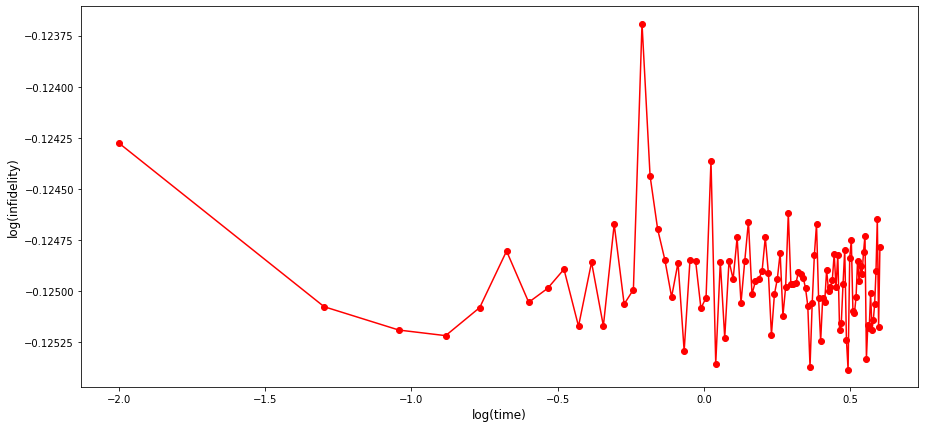

In [116]:
#print(infidel_t)
log_infidelity = np.log10(infidel_t)
log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(log_time, log_infidelity, 'ro-') #Remove the squared to simply see the wavefunction
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)
#plt.xlim(-25, 25) #Set limit on the x-axis. Comment this out if you wish to study the entire plot

In [98]:
#Test the simulator for varying number of samples N (which must be an integer)
startTime = time.time()
t_fixed = 2
N = (2*(lambd**2)*(t_fixed**2)/epsilon) #int omitted to avoid rounding issues

NStart = 0.1 * N
NFinal = 10 * N
NSteps = 20
NValues = np.linspace(NStart, NFinal, NSteps)
NValues = [int(x + 1) for x in NValues] #+1 because Qdrift rounds up in protocol

Sample_infidel_N = []
for i in NValues:
    Sample_infidel = QDRIFT_comp(hj, Hlist, i, t_fixed, Psi_t)
    Sample_infidel_N.append(Sample_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 95.791170835495


Text(0, 0.5, 'log(infidelity)')

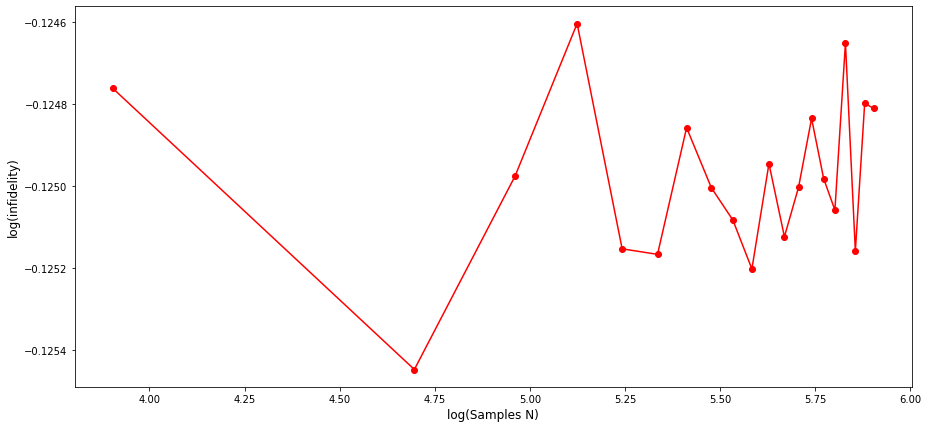

In [104]:
log_infidelity = np.log10(infidel_t)
log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(np.log10(NValues), np.log10(Sample_infidel_N), 'ro-') 
plt.xlabel('log(Samples N)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

### Trotter S2 Performance

In [20]:
#Evaluate Trotter performance for varying t
del t
del Psi_t
startTime = time.time()

tStart = 0.01
tFinal = 2
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

r = int(((tFinal**3)* 4 * (gamma**4))/(epsilon * 3)) * 100 #omitted alphacomm might be prohibitive
Trot_infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ np.conjugate(V_i.T) @ InitialState #recalculate the exact solution
    #r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3))
    Trot_infidel = S2_Comp(hj, Hlist, t, r, Psi_t)
    Trot_infidel_t.append(Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

NameError: name 't' is not defined

In [21]:
#print(Trot_infidel_t)
Trot_log_infidelity = np.log10(Trot_infidel_t)
Trot_log_time = np.log10(times)

plt.figure(figsize = (15, 7))
plt.plot(Trot_log_time, Trot_log_infidelity, 'bo-') #Remove the squared to simply see the wavefunction
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)
#plt.xlim(-25, 25) #Set limit on the x-axis. Comment this out if you wish to study the entire plot

NameError: name 'Trot_infidel_t' is not defined

In [22]:
#derivative of plot above
m = []
for i in range(0, len(times)-1):
    m.append((Trot_log_infidelity[i+1] - Trot_log_infidelity[i]) / (Trot_log_time[i+1] - Trot_log_time[i]))

plt.figure(figsize = (15, 7))
plt.plot(Trot_log_time[0:99], m, 'bo-') #Remove the squared to simply see the wavefunction
plt.xlabel('log(time)', size = 12)
plt.ylabel('d/dlog(t) log(infidelity)', size = 12)

NameError: name 'times' is not defined

In [54]:
#Evaluate Trotter performance for varying r
startTime = time.time()

t_fixed = 1
r = (((t_fixed**3)* 4 * (gamma**4))/(epsilon * 3)) * alphacomm #omit alphacomm if prohibitive, omiited int to avoid rounding error

rStart = 0.01 * r
rFinal = 5 * r
rSteps = 10
rValues = np.linspace(rStart, rFinal, rSteps)
rValues = [int(y+1) for y in rValues]

Trot_infidel_r = []
for i in rValues:
    Trotter_infidel = S2_Comp(hj, Hlist, t_fixed, i, Psi_t)
    Trot_infidel_r.append(Trotter_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 2529.195280790329


Text(0, 0.5, 'log(infidelity)')

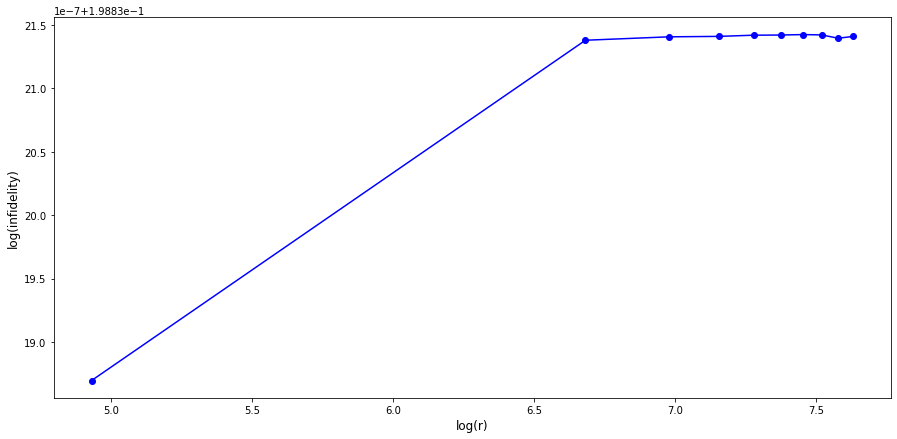

In [105]:
plt.figure (figsize = (15, 7))
plt.plot(np.log10(rValues), np.log10(Trot_infidel_r), "bo-") #Remove the squared to simply see the wavefunction
plt.xlabel('log(r)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

In [80]:
print(alphacomm)

4000.0
